In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()

spark = SparkSession(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/13 07:49:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# IRIS DATASET with PCA

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import when, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
iris_data = spark.read.csv("/Users/komlan/Project_M2/Algo_Big_Data/Data/iris.data", header=False)
columns = ["Petal Length", "Petal Width", "Sepal Length", "Sepal Width", "Name"]
iris_data = iris_data.toDF(*columns)


iris_data = iris_data.withColumn("Petal Length", iris_data["Petal Length"].cast(DoubleType()))
iris_data = iris_data.withColumn("Petal Width", iris_data["Petal Width"].cast(DoubleType()))
iris_data = iris_data.withColumn("Sepal Length", iris_data["Sepal Length"].cast(DoubleType()))
iris_data = iris_data.withColumn("Sepal Width", iris_data["Sepal Width"].cast(DoubleType()))
iris_data = iris_data.withColumn("target",
                     when((iris_data.Name == "Iris-setosa"), lit(0)).
                     when((iris_data.Name == "Iris-versicolor"), lit(1))
                     .otherwise(lit(2)))

iris_data.show()

+------------+-----------+------------+-----------+-----------+------+
|Petal Length|Petal Width|Sepal Length|Sepal Width|       Name|target|
+------------+-----------+------------+-----------+-----------+------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|     0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|     0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|     0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|     0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|     0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|     0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|     0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|     0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|     0|
|         4.9|        3.1|         1.5|        0.1|Iris-setosa|     0|
|         5.4|        3.7|         1.5|        0.2|Iris-setosa|     0|
|     

In [78]:
assembler_raw = VectorAssembler(inputCols = iris_data.columns, outputCol = 'features')
raw_iris = assembler_raw.transform(iris_data).select('features')
raw_iris.show(10)

+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
|[4.6,3.4,1.4,0.3]|
|[5.0,3.4,1.5,0.2]|
|[4.4,2.9,1.4,0.2]|
|[4.9,3.1,1.5,0.1]|
+-----------------+
only showing top 10 rows



## Combiner la partie numerique en une colonne pour permettre l'apprentissage avec Spark

In [70]:
num_columns = ["Petal Length", "Petal Width", "Sepal Length", "Sepal Width"]
assembler = VectorAssembler(inputCols = num_columns, outputCol = 'features')
num_iris = assembler.transform(iris_data).select('features')
num_iris.show()

+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
|[4.6,3.4,1.4,0.3]|
|[5.0,3.4,1.5,0.2]|
|[4.4,2.9,1.4,0.2]|
|[4.9,3.1,1.5,0.1]|
|[5.4,3.7,1.5,0.2]|
|[4.8,3.4,1.6,0.2]|
|[4.8,3.0,1.4,0.1]|
|[4.3,3.0,1.1,0.1]|
|[5.8,4.0,1.2,0.2]|
|[5.7,4.4,1.5,0.4]|
|[5.4,3.9,1.3,0.4]|
|[5.1,3.5,1.4,0.3]|
|[5.7,3.8,1.7,0.3]|
|[5.1,3.8,1.5,0.3]|
+-----------------+
only showing top 20 rows



## Normaliser la matrice

In [71]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures', withMean = True, withStd = True).fit(num_iris)
scaler
iris_scaled = scaler.transform(num_iris)
iris_scaled.show(5)

+-----------------+--------------------+
|         features|      scaledFeatures|
+-----------------+--------------------+
|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|
|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|
|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|
|[4.6,3.1,1.5,0.2]|[-1.5014903898672...|
|[5.0,3.6,1.4,0.2]|[-1.0184371813308...|
+-----------------+--------------------+
only showing top 5 rows



In [72]:
pca = PCA(k=2, inputCol='scaledFeatures', outputCol="pcaFeatures")
model = pca.fit(iris_scaled)
result = pca.setInputCol("features").fit(iris_scaled).transform(iris_scaled)
result.select("pcaFeatures").show(20,truncate=False)

+----------------------------------------+
|pcaFeatures                             |
+----------------------------------------+
|[-2.8271359726790286,-5.641331045573357]|
|[-2.7959524821488464,-5.145166883252942]|
|[-2.62152355816506,-5.17737812120394]   |
|[-2.764905900474242,-5.003599415056977] |
|[-2.782750115951662,-5.648648294377423] |
|[-3.23144573677338,-6.062506444034102]  |
|[-2.6904524156023473,-5.232619219784287]|
|[-2.884861104459158,-5.4851290797692585]|
|[-2.6233845324473424,-4.743925704477377]|
|[-2.837498411063856,-5.2080320270562295]|
|[-3.0048163084440738,-5.96665874448154] |
|[-2.8982003795119207,-5.336244362769227]|
|[-2.723909121785879,-5.086983541937862] |
|[-2.286142651507996,-4.811443821323543] |
|[-2.867799880841831,-6.500918630222419] |
|[-3.1274737739836023,-6.659478075368831]|
|[-2.8888168946571686,-6.132813405405563]|
|[-2.8630203653038504,-5.633860398559853]|
|[-3.3122651363522153,-6.193967818900704]|
|[-2.923996908865239,-5.835197369614937] |
+----------

## Visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


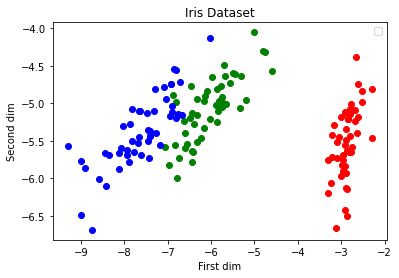

In [73]:
def plot_iris_pca(array, y):
    colors = {0:'r', 1:'g', 2:'b'}

    # create a figure and axis
    fig, ax = plt.subplots()
    # plot each data-point
    for i in range(len(array[:,0])):
        ax.scatter(array[:,0][i], array[:,1][i], color=colors[y[i]])
    # set a title and labels
    ax.set_title('Iris Dataset')
    ax.set_xlabel('First dim')
    ax.set_ylabel('Second dim')

    ax.legend()
    plt.show()
X_pca = result.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)
X_pca
y = [int(row.target) for row in iris_data.select('target').collect()]
plot_iris_pca(X_pca, y)

## Corrélation entre les variables

In [79]:
import pandas as pd
from pyspark.ml.stat import Correlation
corr = Correlation.corr(result, 'features', 'pearson').collect()[0][0]
corr2 = corr.toArray()
corr2 = pd.DataFrame(corr2, columns=num_columns, index = num_columns)
corr2

/Users/komlan/pythonEnv/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Petal Length  Petal Width  Sepal Length  Sepal Width
Petal Length      1.000000    -0.109369      0.871754     0.817954
Petal Width      -0.109369     1.000000     -0.420516    -0.356544
Sepal Length      0.871754    -0.420516      1.000000     0.962757
Sepal Width       0.817954    -0.356544      0.962757     1.000000

In [80]:
s , ax = plt.subplots(figsize =( 12 , 8))
cmap = sns.diverging_palette(10, 250  , as_cmap = True )
s = sns.heatmap(corr2, cmap = cmap, square=True,ax=ax, annot = True,cbar_kws={'shrink' : .9 }, annot_kws = {'fontsize':12})

# Etude du VIN

In [82]:
win_data = spark.read.csv("/Users/komlan/Project_M2/Algo_Big_Data/Data/winequality_white.csv", header=True)
win_data.show(10)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|            7|            0.27|       0.36|          20.7|    0.045|                 45|                 170|  1.001|   3|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|                 14|                 132|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|                 30|                  97| 0.9951|3.26|     0.44|   10.1|      6|
|          7.2|            0.23|       0.32|           8.5|    0.058|                 47|           

In [83]:
win_columns = win_data.columns
win_columns

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [84]:
win_data.describe().toPandas().transpose()

0                    1                     2  \
summary               count                 mean                stddev   
fixed acidity          4898    6.854787668436075    0.8438682276875127   
volatile acidity       4898  0.27824111882401087   0.10079454842486532   
citric acid            4898  0.33419150673743736   0.12101980420298254   
residual sugar         4898    6.391414863209486     5.072057784014878   
chlorides              4898   0.0457723560636995  0.021847968093728805   
free sulfur dioxide    4898    35.30808493262556     17.00713732523259   
total sulfur dioxide   4898   138.36065741118824    42.498064554142985   
density                4898   0.9940273764801896  0.002990906916936997   
pH                     4898   3.1882666394446693   0.15100059961506673   
sulphates              4898   0.4898468762760325   0.11412583394883222   
alcohol                4898   10.514267047770149     1.230620567752269   
quality                4898     5.87790935075541    0.8856385749678322   

                            3        4  
summary                   min      max  
fixed acidity              10      9.9  
volatile acidity         0.08      1.1  
citric acid                 0     1.66  
residual sugar            0.6      9.9  
chlorides               0.009    0.346  
free sulfur dioxide        10       98  
total sulfur dioxide       10       99  
density               0.98711  1.03898  
pH                       2.72     3.82  
sulphates                0.22     1.08  
alcohol                    10      9.9  
quality                     3        9

In [85]:
#Convert types and gather columns
for column in win_columns:
    win_data = win_data.withColumn(column, win_data[column].cast(DoubleType()))

assembler = VectorAssembler(inputCols = win_columns, outputCol = 'features')
num_win = assembler.transform(win_data).select('features')
num_win.show(10)

+--------------------+
|            features|
+--------------------+
|[7.0,0.27,0.36,20...|
|[6.3,0.3,0.34,1.6...|
|[8.1,0.28,0.4,6.9...|
|[7.2,0.23,0.32,8....|
|[7.2,0.23,0.32,8....|
|[8.1,0.28,0.4,6.9...|
|[6.2,0.32,0.16,7....|
|[7.0,0.27,0.36,20...|
|[6.3,0.3,0.34,1.6...|
|[8.1,0.22,0.43,1....|
+--------------------+
only showing top 10 rows



In [86]:
#Normalize the columns
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures', withMean = True, withStd = True).fit(num_win)

win_scaled = scaler.transform(num_win)
win_scaled.show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[7.0,0.27,0.36,20...|[0.17207939201815...|
|[6.3,0.3,0.34,1.6...|[-0.6574340047810...|
|[8.1,0.28,0.4,6.9...|[1.47560044413120...|
|[7.2,0.23,0.32,8....|[0.40908321967507...|
|[7.2,0.23,0.32,8....|[0.40908321967507...|
+--------------------+--------------------+
only showing top 5 rows



In [87]:
#Apply PCA on the win dataset
pca_win = PCA(k=2, inputCol='scaledFeatures', outputCol="pcaFeatures")
model = pca_win.fit(win_scaled)
win_result = pca_win.setInputCol("features").fit(win_scaled).transform(win_scaled)
win_result.select("pcaFeatures").show(20,truncate=False)

+-----------------------------------------+
|pcaFeatures                              |
+-----------------------------------------+
|[-176.50046028594875,0.8800275650125701] |
|[-130.84221658069126,21.076191862824242] |
|[-101.5434197305601,-3.6184642996870795] |
|[-191.8549809891716,3.330468041609325]   |
|[-191.8549809891716,3.330468041609325]   |
|[-101.5434197305601,-3.6184642996870795] |
|[-139.14168486051443,6.610567003907907]  |
|[-176.50046028594875,0.8800275650125701] |
|[-130.84221658069126,21.076191862824242] |
|[-131.596161911265,6.791338120638976]    |
|[-63.51846033007134,5.858534796619275]   |
|[-109.58661055104223,12.132441929974084] |
|[-76.3969225903605,4.197105829884256]    |
|[-150.30445534614418,-8.85773188951017]  |
|[-177.30627513097218,5.302944742051442]  |
|[-115.20006391810684,2.298374591893588]  |
|[-103.19998295674392,-3.0194284722932063]|
|[-79.76382247972037,-8.404060885834097]  |
|[-169.17368588907266,28.432819843606133] |
|[-137.32627376770358,1.97089570

## Correlation Matrix

In [88]:
from pyspark.ml.stat import Correlation
corr_w = Correlation.corr(win_result, 'features', 'pearson').collect()[0][0]
corr2_w = corr_w.toArray()
corr2_w = pd.DataFrame(corr2_w, columns=win_columns, index = win_columns)

/Users/komlan/pythonEnv/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


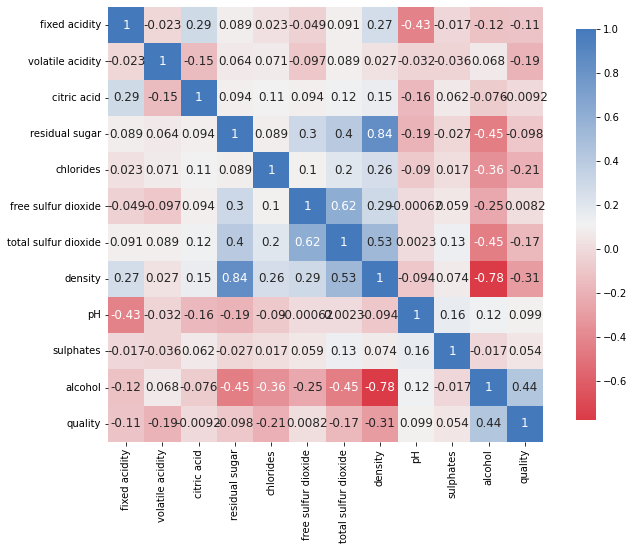

In [89]:
s , ax = plt.subplots(figsize =( 12 , 8))
cmap = sns.diverging_palette(10, 250  , as_cmap = True )
s = sns.heatmap(corr2_w, cmap = cmap, square=True,ax=ax, annot = True,cbar_kws={'shrink' : .9 }, annot_kws = {'fontsize':12})